In [3]:
import copy
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxIterations

# Thông số bài toán

In [4]:
SEED = 1234
rnd.seed(SEED)

DEPOT = 0       # Điểm xuất phát
END = 22        # Điểm kết thúc
SATELLITES = [1, 2]
CUSTOMERS = list(range(3, 22))

L1_CAPACITY = 5000  # Sức chứa của xe tải tầng 1
L2_CAPACITY = 3000  # Sức chứa của xe tầng 2

L1_FLEET = 2   # Số xe tải tầng 1
L2_FLEET = 4   # Số xe tầng 2 (chia đều cho 2 satellite)

L1_SPEED = 60  # Vận tốc của xe tải tầng 1
L2_SPEED = 40  # Vận tốc của xe tầng 2

# Tọa độ các điểm (bao gồm điểm END)
NODE_COORDS = {
    0: (145, 215),
    1: (151, 264),
    2: (159, 261),
    3: (130, 254),
    4: (128, 252),
    5: (163, 247),
    6: (146, 246),
    7: (161, 242),
    8: (142, 239),
    9: (163, 236),
    10: (148, 232),
    11: (128, 231),
    12: (156, 217),
    13: (129, 214),
    14: (146, 208),
    15: (164, 208),
    16: (141, 206),
    17: (147, 193),
    18: (164, 193),
    19: (129, 189),
    20: (155, 185),
    21: (139, 182),
    22: (170, 215)  # END
}

DEMANDS = {
    0: 0,   1: 1100, 2: 700,
    3: 800, 4: 1400, 5: 2100, 6: 400, 7: 800, 8: 100,
    9: 500, 10: 600, 11: 1200, 12: 1300, 13: 1300, 14: 300, 15: 900,
    16: 2100, 17: 1000, 18: 900, 19: 2500, 20: 1800, 21: 700,
    22: 0
}

In [5]:

def euclidean_distance(a, b):
    x1, y1 = NODE_COORDS[a]
    x2, y2 = NODE_COORDS[b]
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Số tuyến xe tầng 2 tối đa cho mỗi satellite (chia đều)
max_routes_sat = {s: L2_FLEET // len(SATELLITES) for s in SATELLITES}

# 2E_VREC

In [6]:
class TwoEVRPState:
    """
    first_echelon: dict của xe tải tầng 1. Mỗi xe có tuyến dạng:
       [DEPOT, s, ... (khách hàng phục vụ bởi L1) ..., s, END]
       (s xuất hiện 2 lần là cố định: để drop-off/pickup xe L2)
    second_echelon: dict của xe tầng 2 theo satellite, mỗi tuyến có dạng:
       [s] + danh sách khách hàng + [s]
    unassigned: danh sách khách hàng chưa được gán.
    """
    def __init__(self, first_echelon, second_echelon, unassigned=None):
        self.first_echelon = first_echelon
        self.second_echelon = second_echelon
        self.unassigned = unassigned if unassigned is not None else []
    
    def copy(self):
        return TwoEVRPState(copy.deepcopy(self.first_echelon),
                            copy.deepcopy(self.second_echelon),
                            self.unassigned.copy())
    
    def objective(self):
        # Tính tổng thời gian di chuyển của xe L1 và L2 (time = distance / speed)
        cost_L1 = 0
        for route in self.first_echelon.values():
            cost_L1 += sum(euclidean_distance(route[i], route[i+1]) / L1_SPEED for i in range(len(route)-1))
        cost_L2 = 0
        for s, routes in self.second_echelon.items():
            for route in routes:
                if route:
                    cost_L2 += euclidean_distance(s, route[0]) / L2_SPEED
                    cost_L2 += sum(euclidean_distance(route[i], route[i+1]) / L2_SPEED for i in range(len(route)-1))
                    cost_L2 += euclidean_distance(route[-1], s) / L2_SPEED
        penalty = 1e6 * len(self.unassigned)
        return cost_L1 + cost_L2 + penalty

# Khởi tạo

In [7]:
def initial_solution():
    """
    - Xe L1: Gán mỗi xe cho một satellite (theo vòng lặp). 
      Khởi tạo tuyến L1 với cấu trúc: [DEPOT, s, s, END]
    - Xe L2: Mỗi satellite có 1 tuyến rỗng ban đầu; nếu không đủ chỗ thì tạo thêm tuyến mới.
    - Các khách hàng được gán chủ yếu cho L2; nếu không gán được thì đưa vào unassigned.
    """
    first_echelon = {}
    for veh in range(L1_FLEET):
        assigned_sat = SATELLITES[veh % len(SATELLITES)]
        first_echelon[veh] = [DEPOT, assigned_sat, assigned_sat, END]
    
    second_echelon = {s: [[]] for s in SATELLITES}
    route_cap = {s: [L2_CAPACITY] for s in SATELLITES}
    unassigned = []
    
    sorted_customers = sorted(CUSTOMERS, key=lambda c: min(euclidean_distance(c, s) for s in SATELLITES))
    for c in sorted_customers:
        s_best = min(SATELLITES, key=lambda s: euclidean_distance(s, c))
        assigned_flag = False
        # Thử gán vào các tuyến hiện có của satellite s_best
        for idx, cap in enumerate(route_cap[s_best]):
            if cap >= DEMANDS[c]:
                second_echelon[s_best][idx].append(c)
                route_cap[s_best][idx] -= DEMANDS[c]
                assigned_flag = True
                break
        # Nếu không gán được, tạo tuyến mới cho satellite s_best (nếu chưa vượt quá max_routes_sat)
        if not assigned_flag:
            if len(second_echelon[s_best]) < max_routes_sat[s_best]:
                second_echelon[s_best].append([c])
                route_cap[s_best].append(L2_CAPACITY - DEMANDS[c])
                assigned_flag = True
            else:
                unassigned.append(c)
    
    return TwoEVRPState(first_echelon, second_echelon, unassigned)

# Destroy and Repair

In [8]:
def random_removal(state, rng, num_remove=3):
    """
    Loại bỏ ngẫu nhiên một số khách hàng khỏi tuyến L1 và L2
    (chỉ loại bỏ các node thuộc CUSTOMERS).
    """
    state = state.copy()
    customers_to_remove = rng.choice(CUSTOMERS, num_remove, replace=False)
    
    # L1: Loại bỏ các khách hàng, giữ lại Depot, End, Satellite
    for veh, route in state.first_echelon.items():
        new_route = [
            node for node in route
            if (node not in customers_to_remove) or (node in [DEPOT, END] or node in SATELLITES)
        ]
        state.first_echelon[veh] = new_route
    
    # L2: Loại bỏ khỏi các tuyến
    for s, routes in state.second_echelon.items():
        for r in routes:
            r[:] = [c for c in r if c not in customers_to_remove]
    
    state.unassigned.extend(customers_to_remove)
    return state

# Hàm tính dung lượng đã sử dụng của xe L1
def used_capacity_L1(route):
    return sum(DEMANDS[c] for c in route if c in CUSTOMERS)

# Hàm tính dung lượng đã sử dụng của xe L2
def used_capacity_L2(route2):
    return sum(DEMANDS[c] for c in route2)

# --------------------
# REPAIR
# --------------------
def greedy_repair(state, rng):
    """
    Với mỗi khách hàng trong unassigned, xét 2 option:
      Option 1: Chèn vào tuyến L1 (xe tải) nếu đủ capacity.
      Option 2: Chèn vào tuyến L2 tại satellite (kiểm tra capacity).
                Nếu không tìm thấy tuyến L2 hiện có khả thi tại satellite, 
                thì chỉ tạo tuyến mới cho L2 tại satellite đó (không tạo tuyến mới ở depot).
    Chọn vị trí chèn có extra cost (theo thời gian) nhỏ nhất.
    """
    state = state.copy()
    rng.shuffle(state.unassigned)
    
    inserted_customers = []
    
    for c in state.unassigned:
        best_option = None
        best_extra_cost = float('inf')
        
        # Option 1: Chèn vào L1
        for veh, route in state.first_echelon.items():
            if used_capacity_L1(route) + DEMANDS[c] <= L1_CAPACITY:
                # Các vị trí hợp lệ: từ index 2 đến index len(route)-1 (không chèn trước END)
                for pos in range(2, len(route) - 1):
                    prev_node = route[pos - 1]
                    next_node = route[pos]
                    extra_cost = (euclidean_distance(prev_node, c) / L1_SPEED +
                                  euclidean_distance(c, next_node) / L1_SPEED -
                                  euclidean_distance(prev_node, next_node) / L1_SPEED)
                    if extra_cost < best_extra_cost:
                        best_extra_cost = extra_cost
                        best_option = ('L1', veh, pos)
        
        # Option 2: Chèn vào L2 tại satellite
        for s in SATELLITES:
            feasible_found = False
            for idx, route2 in enumerate(state.second_echelon[s]):
                if used_capacity_L2(route2) + DEMANDS[c] <= L2_CAPACITY:
                    # Nếu tuyến L2 hiện có rỗng
                    if len(route2) == 0:
                        extra = (euclidean_distance(s, c) / L2_SPEED +
                                 euclidean_distance(c, s) / L2_SPEED)
                        if extra < best_extra_cost:
                            best_extra_cost = extra
                            best_option = ('L2', s, idx, 0)
                    else:
                        # Nếu tuyến đã có khách
                        last = route2[-1]
                        extra = (euclidean_distance(last, c) / L2_SPEED +
                                 euclidean_distance(c, s) / L2_SPEED -
                                 euclidean_distance(last, s) / L2_SPEED)
                        if extra < best_extra_cost:
                            best_extra_cost = extra
                            best_option = ('L2', s, idx, len(route2))
                    feasible_found = True
            # Nếu không tìm thấy tuyến nào đủ capacity tại satellite s,
            # thì tạo tuyến mới cho L2 tại satellite đó (chỉ tạo tuyến mới ở satellite)
            if not feasible_found and len(state.second_echelon[s]) < max_routes_sat[s]:
                extra_new = (euclidean_distance(s, c) / L2_SPEED +
                             euclidean_distance(c, s) / L2_SPEED)
                if extra_new < best_extra_cost:
                    best_extra_cost = extra_new
                    best_option = ('L2_new', s)
        
        # Thực hiện chèn khách hàng dựa theo lựa chọn tốt nhất
        if best_option is None:
            continue  # Không chèn được, giữ lại khách hàng trong unassigned
        else:
            if best_option[0] == 'L1':
                _, veh, pos = best_option
                state.first_echelon[veh].insert(pos, c)
                inserted_customers.append(c)
            elif best_option[0] == 'L2':
                _, s, idx, pos = best_option
                state.second_echelon[s][idx].insert(pos, c)
                inserted_customers.append(c)
            elif best_option[0] == 'L2_new':
                _, s = best_option
                new_route = [c]
                state.second_echelon[s].append(new_route)
                inserted_customers.append(c)
    
    # Loại bỏ khách hàng đã chèn thành công khỏi unassigned
    state.unassigned = [uc for uc in state.unassigned if uc not in inserted_customers]
    return state

# Chạy ALNS

In [9]:

rng = rnd.default_rng(SEED)
init_state = initial_solution()

alns = ALNS(rng)
alns.add_destroy_operator(random_removal)
alns.add_repair_operator(greedy_repair)

accept = RecordToRecordTravel.autofit(init_state.objective(), 0.02, 0, 10000)
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
stop = MaxIterations(1000)

result = alns.iterate(init_state, select, accept, stop)
best = result.best_state

print("Best solution cost:", best.objective())
print("\n--- L1 Routes (Trucks):")
for veh, route in best.first_echelon.items():
    print(f"Truck {veh}: {route}")
print("\n--- L2 Routes (Vehicles at Satellite):")
for s, routes in best.second_echelon.items():
    for idx, r in enumerate(routes):
        print(f"Satellite {s}, Vehicle {idx+1}: {[s] + r + [s]}")



Best solution cost: 18.470917197612874

--- L1 Routes (Trucks):
Truck 0: [0, 1, np.int64(17), np.int64(21), np.int64(20), np.int64(15), np.int64(9), 1, 22]
Truck 1: [0, 2, np.int64(14), np.int64(19), np.int64(18), np.int64(12), 2, 22]

--- L2 Routes (Vehicles at Satellite):
Satellite 1, Vehicle 1: [1, np.int64(5), np.int64(10), 1]
Satellite 1, Vehicle 2: [1, np.int64(4), np.int64(3), 1]
Satellite 2, Vehicle 1: [2, np.int64(7), np.int64(16), 2]
Satellite 2, Vehicle 2: [2, np.int64(6), np.int64(13), np.int64(11), np.int64(8), 2]


# Sơ đồ

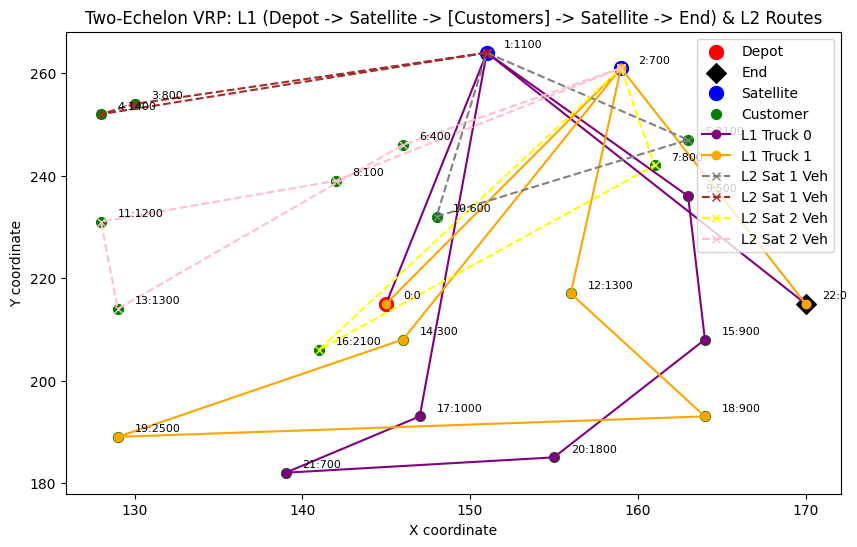

In [10]:

plt.figure(figsize=(10, 6))

plt.scatter(NODE_COORDS[DEPOT][0], NODE_COORDS[DEPOT][1], color='red', s=100, label='Depot')
plt.scatter(NODE_COORDS[END][0], NODE_COORDS[END][1], color='black', s=100, marker='D', label='End')
for idx, s in enumerate(SATELLITES):
    plt.scatter(NODE_COORDS[s][0], NODE_COORDS[s][1], color='blue', s=100, label='Satellite' if idx==0 else "")
for idx, c in enumerate(CUSTOMERS):
    plt.scatter(NODE_COORDS[c][0], NODE_COORDS[c][1], color='green', s=50, label='Customer' if idx==0 else "")

colors_L1 = ['purple', 'orange', 'magenta', 'cyan']
for veh, route in best.first_echelon.items():
    color = colors_L1[veh % len(colors_L1)]
    xs = [NODE_COORDS[n][0] for n in route]
    ys = [NODE_COORDS[n][1] for n in route]
    plt.plot(xs, ys, color=color, marker='o', label=f'L1 Truck {veh}')

colors_L2 = ['gray', 'brown', 'yellow', 'pink']
color_idx = 0
for s, routes in best.second_echelon.items():
    for route in routes:
        full_route = [s] + route + [s]
        color = colors_L2[color_idx % len(colors_L2)]
        xs = [NODE_COORDS[n][0] for n in full_route]
        ys = [NODE_COORDS[n][1] for n in full_route]
        plt.plot(xs, ys, linestyle='--', marker='x', color=color, label=f'L2 Sat {s} Veh')
        color_idx += 1

for node, coord in NODE_COORDS.items():
    x, y = coord
    plt.text(x + 1, y + 1, f"{node}:{DEMANDS[node]}", fontsize=8, color='black')

plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Two-Echelon VRP: L1 (Depot -> Satellite -> [Customers] -> Satellite -> End) & L2 Routes")
plt.legend()
plt.show()
